In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# Set style for plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Cell 2: Load and inspect the data
df = pd.read_csv('credit_card_fraud_dataset.csv')

# Display basic info
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nData types and missing values:")
display(df.info())

print("\nSummary statistics:")
display(df.describe())

Dataset shape: (100000, 7)

First 5 rows:


,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0



Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


None


Summary statistics:


,TransactionID,Amount,MerchantID,IsFraud
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,2497.092666,501.676070,0.010000
std,28867.657797,1442.415999,288.715868,0.099499
min,1.000000,1.050000,1.000000,0.000000
25%,25000.750000,1247.955000,252.000000,0.000000
50%,50000.500000,2496.500000,503.000000,0.000000
75%,75000.250000,3743.592500,753.000000,0.000000
max,100000.000000,4999.770000,1000.000000,1.000000


Fraud distribution:
IsFraud
0    99000
1     1000
Name: count, dtype: int64


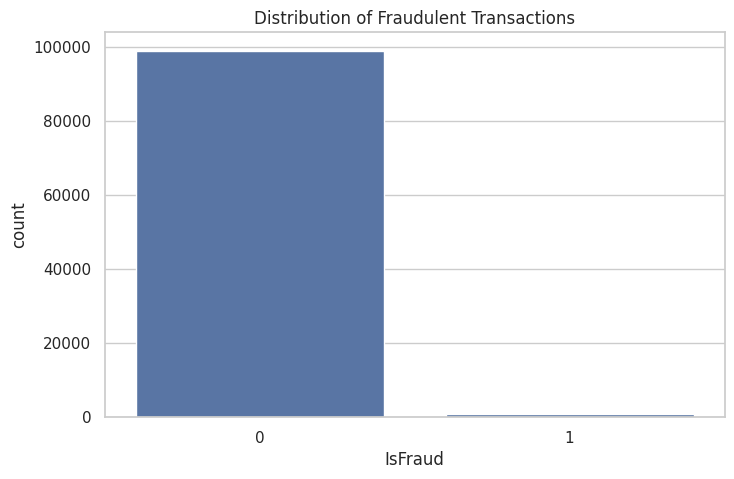

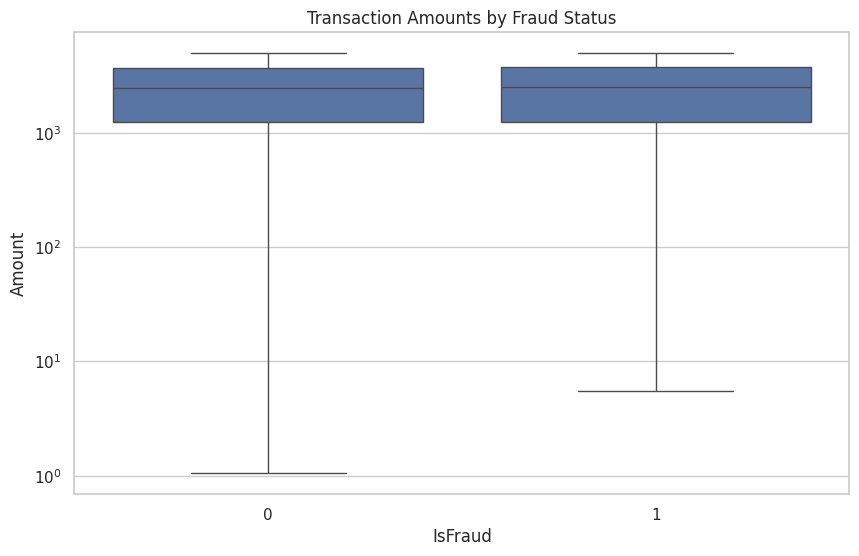

In [3]:
# Cell 3: Exploratory Data Analysis
# Fraud distribution
fraud_counts = df['IsFraud'].value_counts()
print("Fraud distribution:")
print(fraud_counts)

plt.figure(figsize=(8, 5))
sns.countplot(x='IsFraud', data=df)
plt.title('Distribution of Fraudulent Transactions')
plt.show()

# Transaction amounts by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(x='IsFraud', y='Amount', data=df)
plt.yscale('log')  # Log scale for better visualization
plt.title('Transaction Amounts by Fraud Status')
plt.show()

In [4]:
# Cell 4: Feature Engineering
# Extract time features from TransactionDate
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['Hour'] = df['TransactionDate'].dt.hour
df['DayOfWeek'] = df['TransactionDate'].dt.dayofweek
df['DayOfMonth'] = df['TransactionDate'].dt.day

# Encode categorical variables
le = LabelEncoder()
df['TransactionType'] = le.fit_transform(df['TransactionType'])
df['Location'] = le.fit_transform(df['Location'])

# Display new features
print("\nData with new features:")
display(df[['TransactionID', 'Hour', 'DayOfWeek', 'DayOfMonth', 'TransactionType', 'Location']].head())


Data with new features:


,TransactionID,Hour,DayOfWeek,DayOfMonth,TransactionType,Location
0,1,14,2,3,1,7
1,2,13,1,19,1,1
2,3,10,0,8,0,4
3,4,23,5,13,0,5
4,5,18,4,12,0,6


In [5]:
# Cell 5: Prepare data for modeling
# Select features and target
features = ['Amount', 'MerchantID', 'TransactionType', 'Location', 'Hour', 'DayOfWeek', 'DayOfMonth']
X = df[features]
y = df['IsFraud']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", pd.Series(y_train_smote).value_counts())

Before SMOTE: IsFraud
0    69300
1      700
Name: count, dtype: int64
After SMOTE: IsFraud
0    69300
1    69300
Name: count, dtype: int64


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     29700
           1       0.01      0.04      0.02       300

    accuracy                           0.95     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.98      0.95      0.97     30000


Confusion Matrix:
[[28576  1124]
 [  289    11]]

ROC AUC Score: 0.5066314253647587


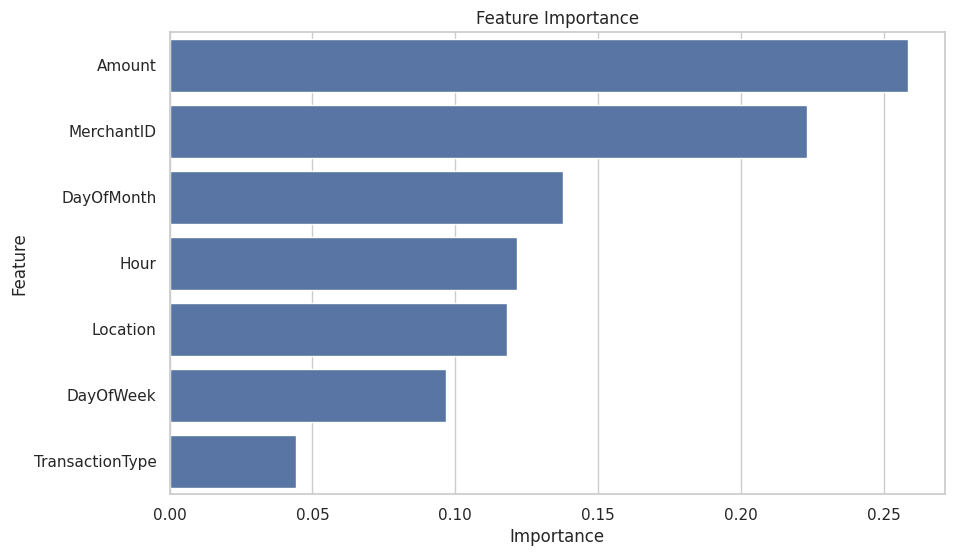

In [6]:
# Cell 6: Build and evaluate model
# Initialize and train Random Forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

# Evaluate model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

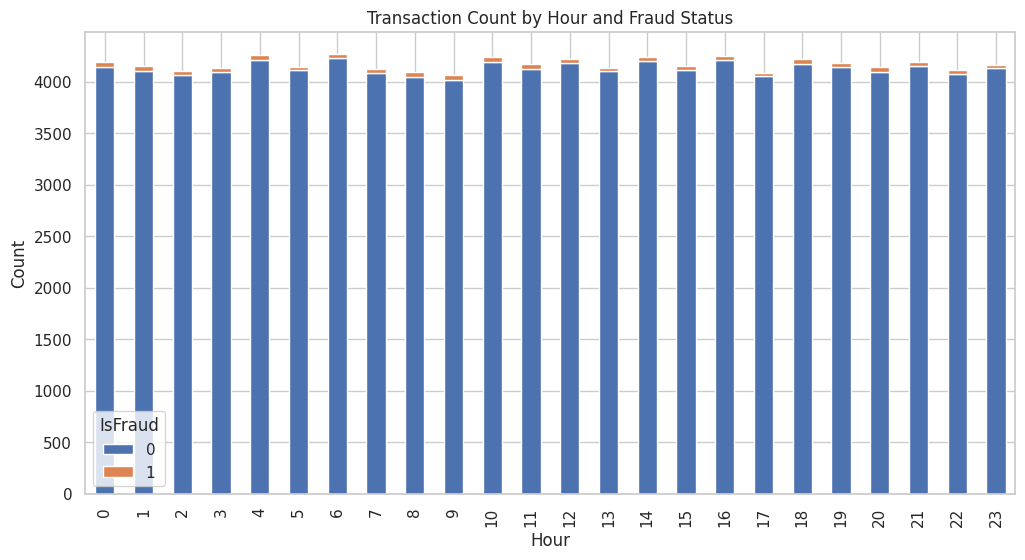

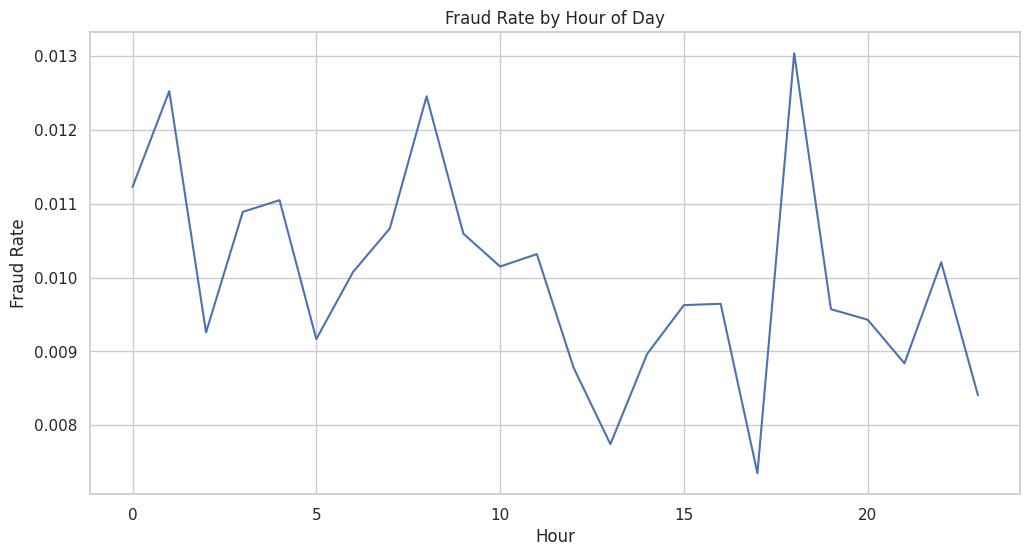

In [7]:
# Cell 7: Additional Analysis - Time Patterns of Fraud
# Plot fraud by hour of day
fraud_by_hour = df.groupby(['Hour', 'IsFraud']).size().unstack()
fraud_by_hour.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Transaction Count by Hour and Fraud Status')
plt.ylabel('Count')
plt.show()

# Fraud rate by hour
fraud_rate_by_hour = df.groupby('Hour')['IsFraud'].mean()
plt.figure(figsize=(12, 6))
fraud_rate_by_hour.plot(kind='line')
plt.title('Fraud Rate by Hour of Day')
plt.ylabel('Fraud Rate')
plt.show()

Merchants with most fraud cases:
MerchantID
583    5
958    5
640    5
156    5
276    4
dtype: int64


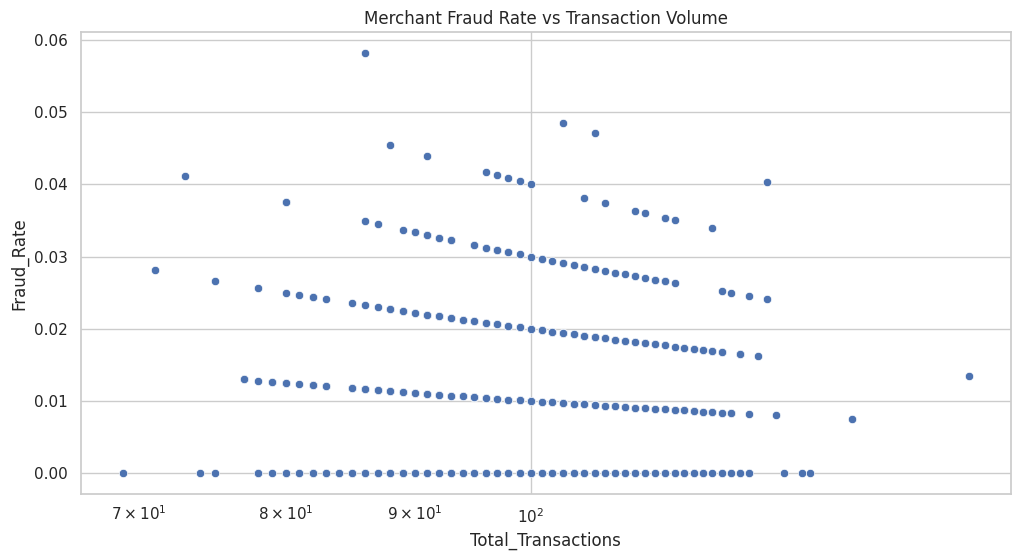

In [8]:
# Cell 8: Merchant Analysis
# Top merchants with fraud
fraud_by_merchant = df[df['IsFraud'] == 1].groupby('MerchantID').size().sort_values(ascending=False)
print("Merchants with most fraud cases:")
print(fraud_by_merchant.head())

# Plot transaction counts vs fraud rate by merchant
merchant_stats = df.groupby('MerchantID').agg(
    Total_Transactions=('IsFraud', 'count'),
    Fraud_Count=('IsFraud', 'sum')
).sort_values('Total_Transactions', ascending=False)
merchant_stats['Fraud_Rate'] = merchant_stats['Fraud_Count'] / merchant_stats['Total_Transactions']

plt.figure(figsize=(12, 6))
sns.scatterplot(x='Total_Transactions', y='Fraud_Rate', data=merchant_stats)
plt.title('Merchant Fraud Rate vs Transaction Volume')
plt.xscale('log')
plt.show()

In [9]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_smote, y_train_smote)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob_dt))


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     29700
           1       0.01      0.07      0.02       300

    accuracy                           0.92     30000
   macro avg       0.50      0.50      0.49     30000
weighted avg       0.98      0.92      0.95     30000

ROC AUC Score: 0.49606060606060604


In [10]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_smote, y_train_smote)

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob_lr))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.59      0.74     29700
           1       0.01      0.44      0.02       300

    accuracy                           0.59     30000
   macro avg       0.50      0.52      0.38     30000
weighted avg       0.98      0.59      0.74     30000

ROC AUC Score: 0.5234250280583613


In [11]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_smote, y_train_smote)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:49:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91     29700
           1       0.01      0.13      0.02       300

    accuracy                           0.84     30000
   macro avg       0.50      0.49      0.46     30000
weighted avg       0.98      0.84      0.90     30000

ROC AUC Score: 0.5080929292929293


<ipython-input-12-2d646b2a4c04>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=roc_scores, palette='Set2')


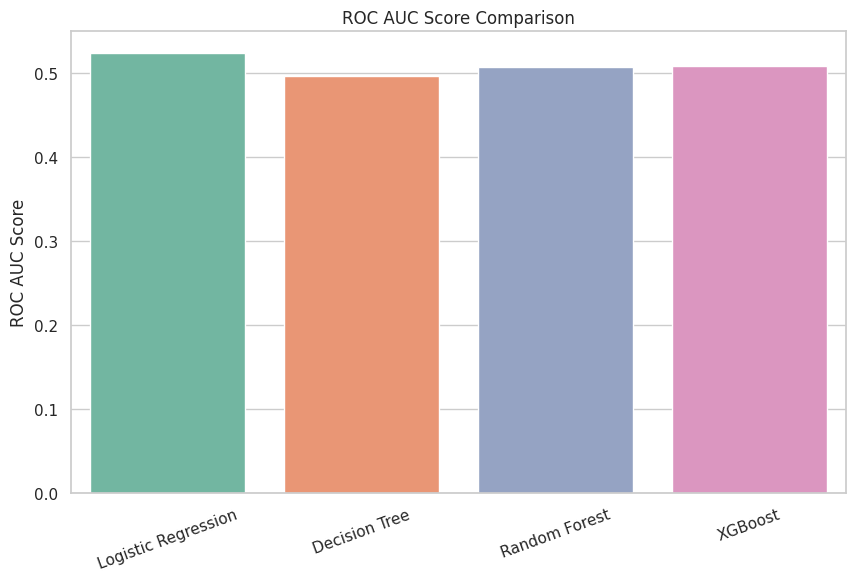

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
roc_scores = [roc_auc_score(y_test, y_prob_lr),
              roc_auc_score(y_test, y_prob_dt),
              roc_auc_score(y_test, y_prob),
              roc_auc_score(y_test, y_prob_xgb)]

plt.figure(figsize=(10,6))
sns.barplot(x=models, y=roc_scores, palette='Set2')
plt.title('ROC AUC Score Comparison')
plt.ylabel('ROC AUC Score')
plt.xticks(rotation=20)
plt.show()


In [13]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
optimal_idx = np.argmax(2 * precision * recall / (precision + recall))  # F1
optimal_threshold = thresholds[optimal_idx]
print("Optimal Threshold:", optimal_threshold)

# Apply threshold
y_pred_thresh = (y_prob >= optimal_threshold).astype(int)


Optimal Threshold: 0.71


<ipython-input-13-664dc5513080>:4: RuntimeWarning: invalid value encountered in divide
  optimal_idx = np.argmax(2 * precision * recall / (precision + recall))  # F1


In [14]:
df['IsWeekend'] = df['TransactionDate'].dt.weekday >= 5
df['IsNight'] = df['Hour'].between(0, 6).astype(int)


In [15]:
from sklearn.metrics import average_precision_score
print("PR AUC Score:", average_precision_score(y_test, y_prob))


PR AUC Score: 0.010231637355419612
